In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from neurodsp import filt
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra

from scipy import signal

from sklearn.decomposition import FastICA, PCA

import time
import pyeeg



In [2]:
Pkl_Filename = 'raw_data_recording-8ch.pkl'
Pkl_Filename_2 = 'raw_data_recording-8ch-2.pkl'
data = []
data_2 = []
with open(Pkl_Filename, 'rb') as file:
    data = pickle.load(file)
    
with open(Pkl_Filename_2, 'rb') as file:
    data_2 = pickle.load(file)
    
print(data)
print(data_2)

[array([[0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        8.60000000e+01, 8.70000000e+01, 8.80000000e+01],
       [0.00000000e+00, 2.02571848e+04, 2.02551508e+04, ...,
        2.14958515e+04, 2.12548549e+04, 2.04841668e+04],
       [0.00000000e+00, 9.69527032e+04, 9.67566784e+04, ...,
        9.55015833e+04, 9.58104173e+04, 9.66560732e+04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.61473081e+09, 1.61473081e+09, 1.61473081e+09, ...,
        1.61473081e+09, 1.61473081e+09, 1.61473081e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), array([[8.90000000e+01, 9.00000000e+01, 9.10000000e+01, ...,
        4.10000000e+01, 4.20000000e+01, 4.30000000e+01],
       [2.03097785e+04, 2.13675748e+04, 2.13824834e+04, ...,
        2.10941683e+04, 2.15628620e+04, 2.16045927e+04],
       [9.66848399e+04, 9.56283400e+04, 9

In [3]:
def assemble_sort_raw_data(raw_data):
    sequenced_data = []
    for chunck in data:
        if len(sequenced_data) == 0:
            sequenced_data = chunck
        else:
            sequenced_data = np.concatenate((sequenced_data, chunck), axis=1)
        
    # sort by the time ch, 22 (brainflow)
    sorted_data = sequenced_data[:,sequenced_data[22].argsort()]
    sorted_data[22] = sorted_data[22] - min(sorted_data[22])
    
    return sorted_data

In [4]:
def get_event_list(sorted_data):
    event_list = []
    for i in range(sorted_data.shape[1]):
        e_label = sorted_data[23][i]
        e_time = sorted_data[22][i]
        if e_label != 0:
            event_list.append([e_label, e_time, i])
            
        
    return event_list

In [5]:
def filter_eeg(ch_datas, sample_rate, f_range):
    filtered = []
    for ch in ch_datas:
        sig_filt = filt.filter_signal(ch,sample_rate, 'bandpass', f_range, filter_type='iir', butterworth_order=2)
        test_filt = filt.filter_signal(sig_filt, sample_rate, 'bandstop', (58,62), n_seconds=1)
        num_nans = sum(np.isnan(test_filt))
        sig_filt = np.concatenate(([0]*(num_nans//2), sig_filt, [0]*(num_nans//2)))
        sig_filt = filt.filter_signal(sig_filt, sample_rate, 'bandstop', (58, 62), n_seconds=1)
        sig_filt = sig_filt[~np.isnan(sig_filt)]
        
        filtered.append(sig_filt)
    
    return np.array(filtered)

In [6]:
def plot_all_channels(ch_data):
    figure(figsize=(12,8))
    for ch in ch_data:
        plt.plot(ch)

In [7]:
raw_data = data+data_2
sorted_data = assemble_sort_raw_data(raw_data)

event_list = get_event_list(sorted_data)
ch_data = sorted_data[1:9]

In [8]:
ch_data = filter_eeg(ch_data, 250, (0.5,55))

/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/filter.py:96: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


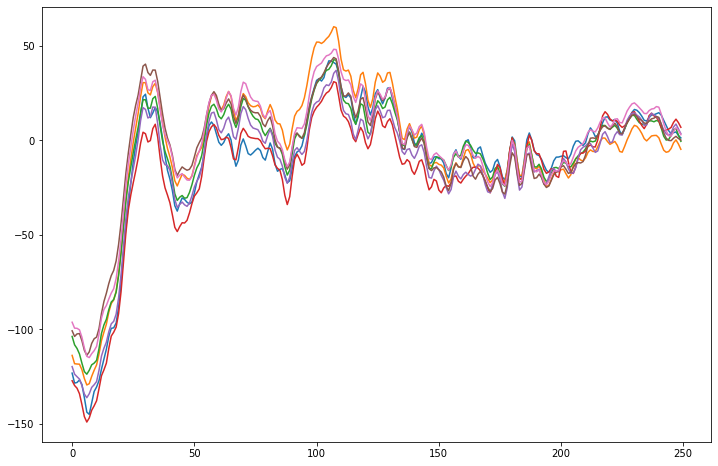

In [9]:
e_range = [2500, 2750]
plot_all_channels(ch_data[1:,e_range[0]:e_range[1]])

In [10]:
test = np.array([5,6,7], dtype=np.float64)
test -= np.mean(test)
test /= np.std(test)
test
# test / np.linalg.norm(test)
ch_data_T = ch_data[:,e_range[0]:e_range[1]].T
ch_data_T.shape
ch_data_T_2 = ch_data[:,e_range[1]:e_range[1]+250].T

/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


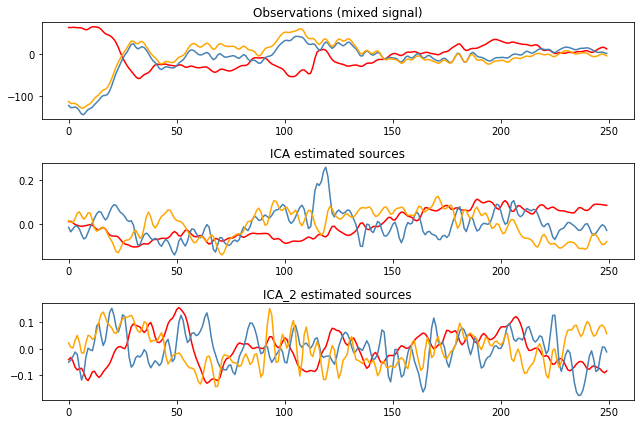

8.12283700000016


In [11]:
# compute ICA
ica = FastICA(n_components=4)
start_time = time.perf_counter() 
S_ = ica.fit_transform(ch_data_T)  # Get the estimated sources
end_time = time.perf_counter()
S_2 = ica.fit_transform(ch_data_T_2)
A_ = ica.mixing_  # Get estimated mixing matrix

# compute PCA
pca = PCA(n_components=4)
H = pca.fit_transform(ch_data_T)  # estimate PCA sources

plt.figure(figsize=(9, 6))

models = [ch_data_T, S_, S_2]
names = ['Observations (mixed signal)',
         'ICA estimated sources',
         'ICA_2 estimated sources']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()
print((end_time - start_time)*1000)

Populating the interactive namespace from numpy and matplotlib


/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


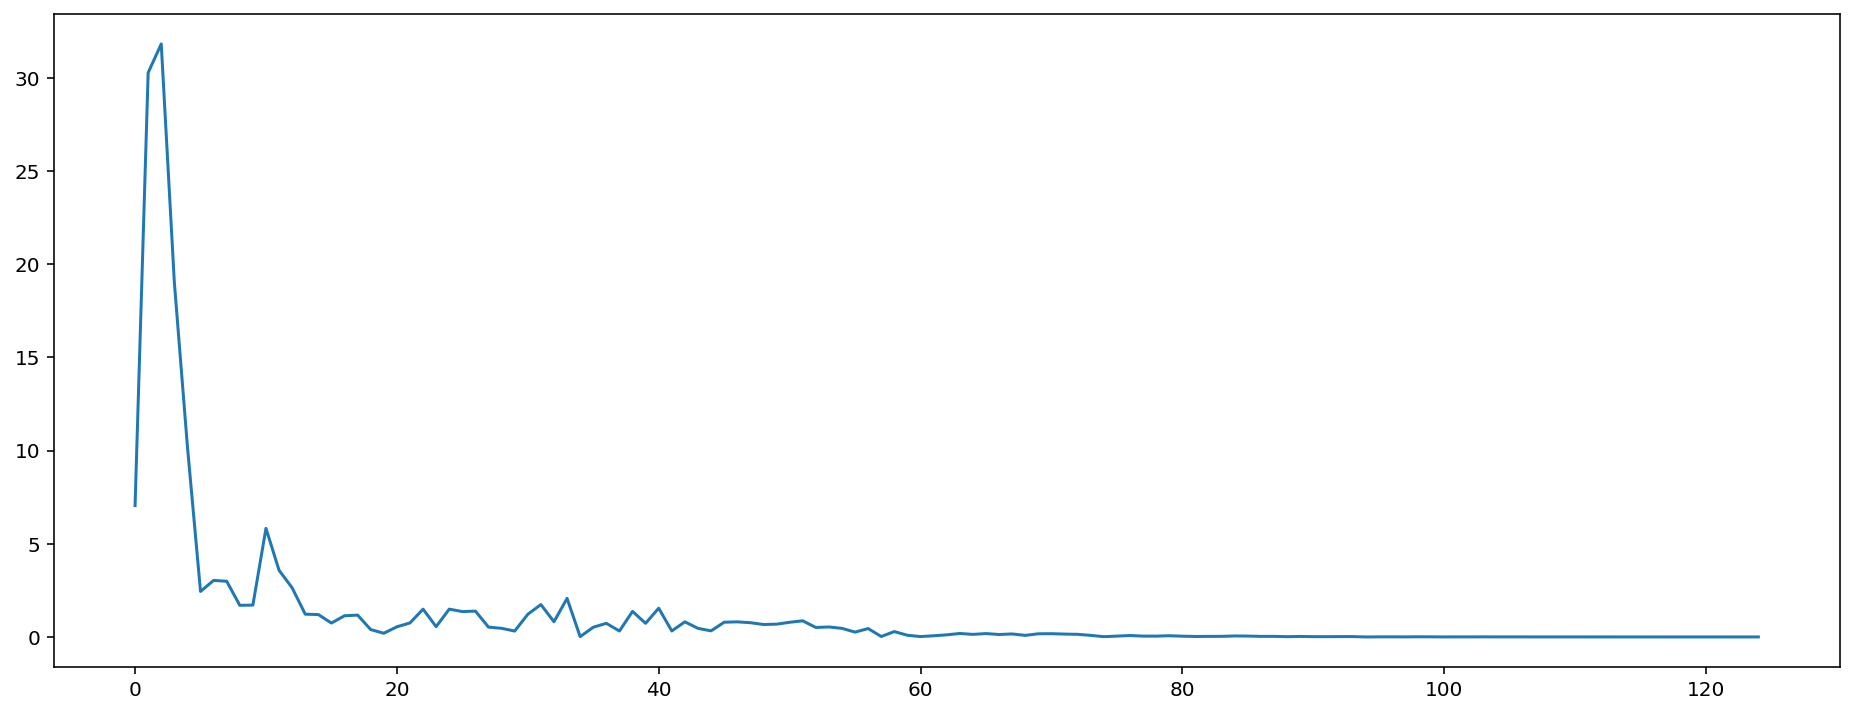

In [12]:
%config InlineBackend.figure_format = 'retina'
%pylab inline

def plot_ch_fft(ch_data):
    # Number of sampling points
    N = len(ch_data)
    # Sample spacing
    T = 1.0/250.0
#     x = np.linspace(0, N*T, N)
    fourier = np.fft.fft(ch_data)
    xf = np.linspace(0, 1//(2*T), N//2)
#     freq = np.fft.fftfreq(250)
    figure(figsize=(16,6))
#     plt.plot(freq, abs(fourier.real))
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
#     print(fourier)
#     print(2.0/N * np.abs(fourier[:N//2]))
    plt.plot(xf, 2.0/N * np.abs(fourier[:N//2]))
    
plot_ch_fft(ch_data[4][10500:10750])
# print(ch_data[4][2500:2750].shape)

Populating the interactive namespace from numpy and matplotlib
(250,)
(125,)


Text(0.5, 1.0, 'FFT')

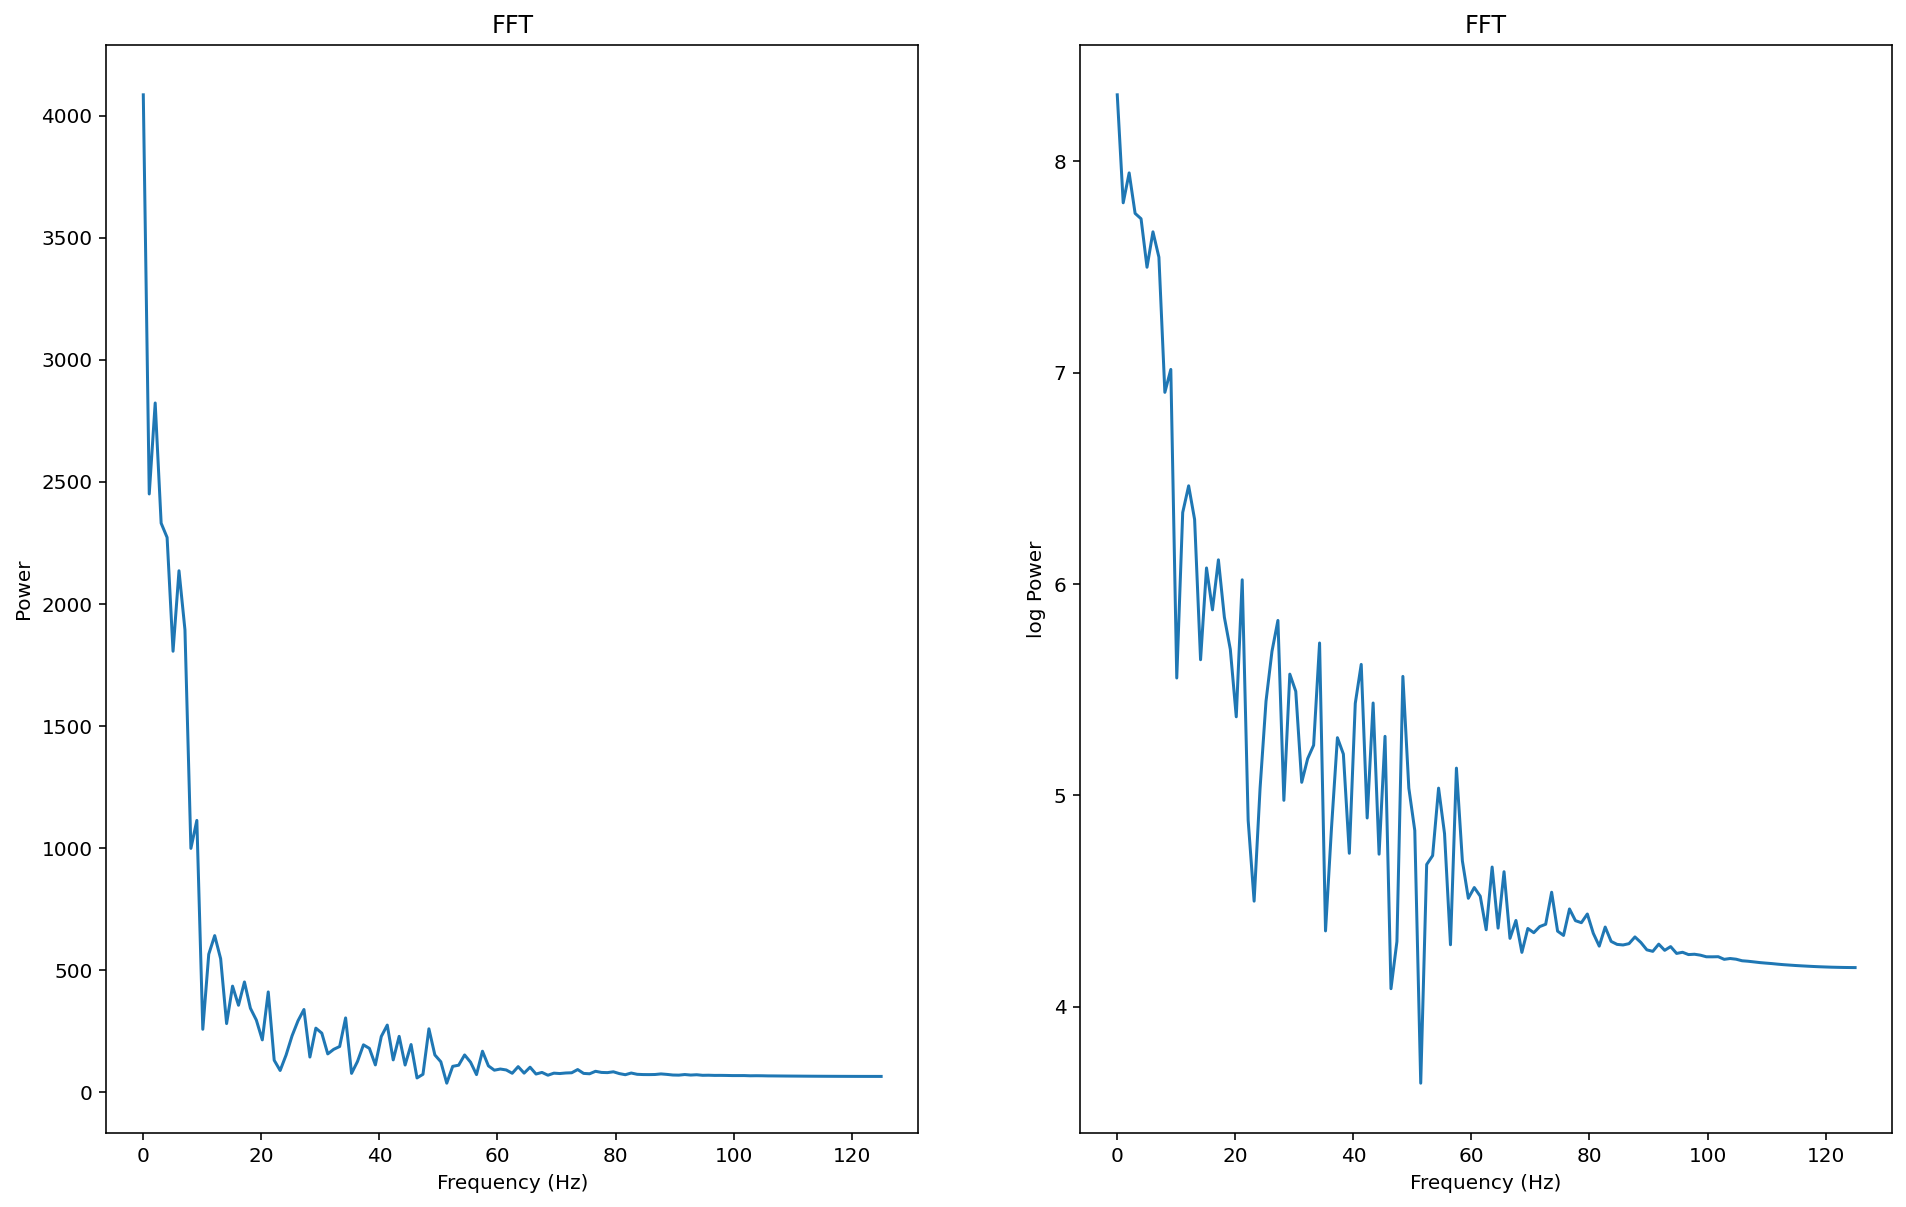

In [13]:
%config InlineBackend.figure_format = 'retina'
%pylab inline

ch_data_T = ch_data[:,e_range[0]:e_range[1]].T
fourier = np.fft.fft(ch_data_T[:,4])
fx_step_size = 250/len(ch_data_T)
nyq = .5*250
total_steps = int(nyq/fx_step_size)
print(ch_data_T[:,4].shape)
fx_bins = np.linspace(0, nyq, total_steps)
print(fx_bins.shape)

figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.plot(fx_bins[0:2000],abs(fourier[0:2000][:125])) #any frequencies above 200 Hz are probably noise
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT')

plt.subplot(1,2,2)
plt.plot(fx_bins[0:2000],log(abs(fourier[0:2000][:125]))) #any frequencies above 200 Hz are probably noise
plt.ylabel('log Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT')

(250, 8)


<BarContainer object of 4 artists>

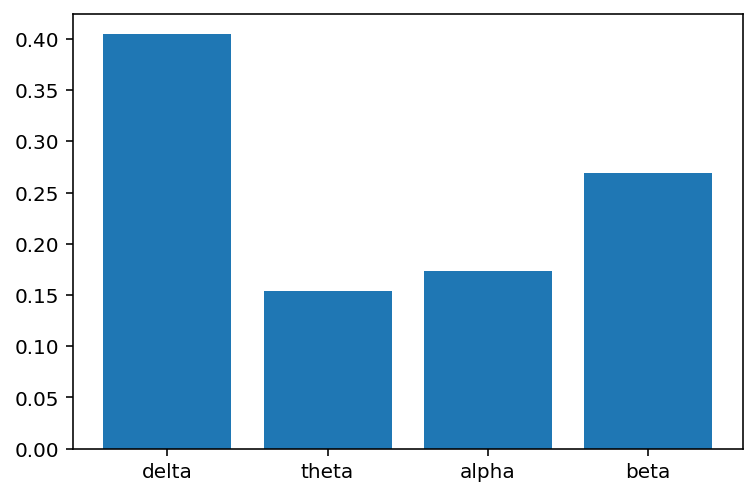

In [14]:
X = ch_data[4,5000:6000].T
print(ch_data_T.shape)
bins = [0.5,4,7,12,30] # delta, theta, alpha and beta

power, power_ratio = pyeeg.bin_power(X, bins, 250.0)
p_r = np.array(power_ratio)
p = np.array(power)
plt.bar(['delta', 'theta', 'alpha', 'beta'],p_r)

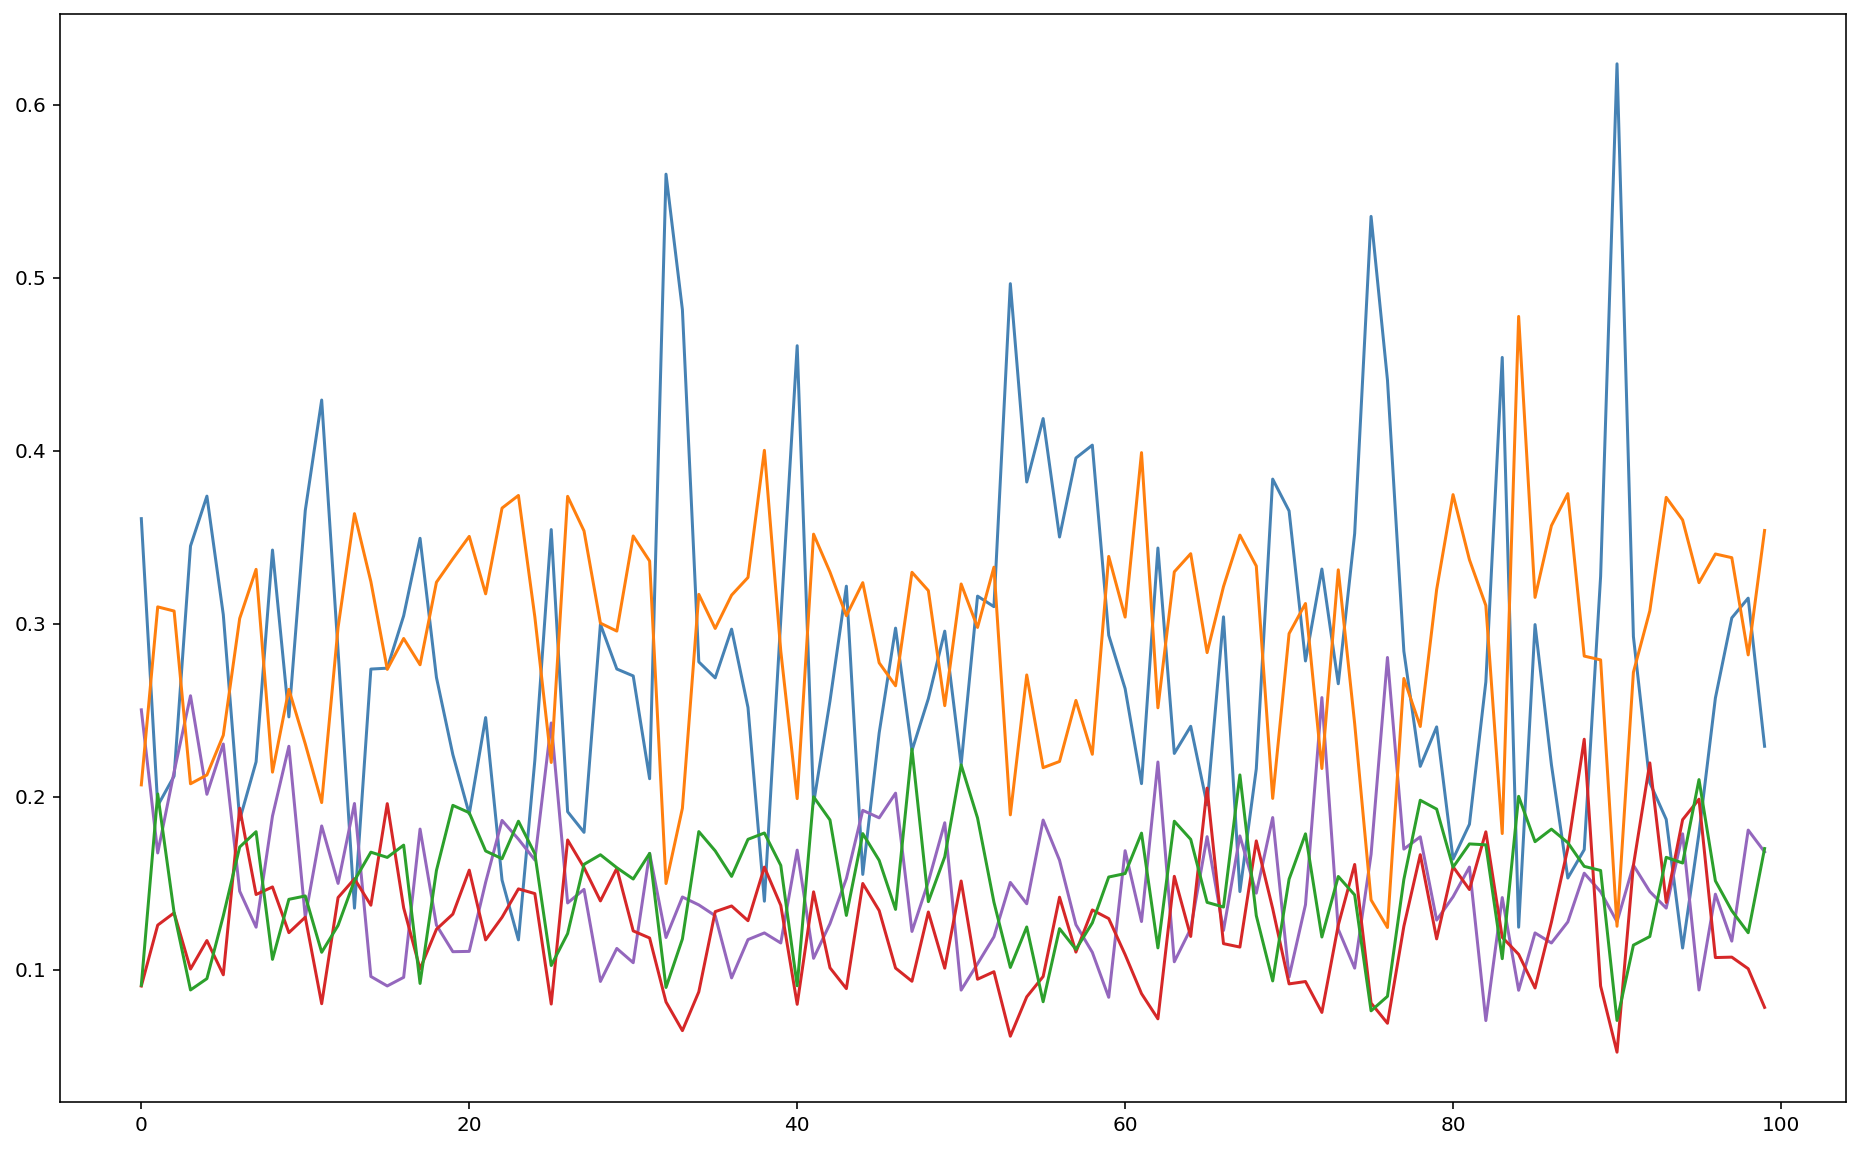

In [15]:
bins = [0.5,4,8,12,35,55] # delta, theta, alpha and beta
labels = ['delta', 'theta', 'alpha', 'beta', 'gamma']
samples = 100

acc = []
for i in range(samples):
    b = 2500
    X = ch_data[4,b+i*250:b+(i+1)*250].T
    power, power_ratio = pyeeg.bin_power(X, bins, 250.0)
    acc.append(np.array(power_ratio))
    
acc = np.array(acc).T
xrange = np.arange(0,samples)
figure(figsize=(16,10))
plt.plot(xrange, acc[0], color='steelblue') # delta
plt.plot(xrange, acc[1], color='tab:purple') # theta
plt.plot(xrange, acc[2], color='tab:red') # alpha
plt.plot(xrange, acc[3], color='tab:orange') # beta
plt.plot(xrange, acc[4], color='tab:green') # gamma

(array([31.27518751, 16.22516209, 74.78830248, 31.84730078, 22.89779864,
        15.61700084,  7.43754179, 14.42644825, 10.59795775,  8.4954745 ,
        13.06305033,  7.3988597 ,  3.78860465,  0.58764136,  1.76498296,
         1.30161192,  0.56661377,  0.28476591,  0.07828188,  0.12636072,
         0.07749076,  1.46866013,  1.33050595,  0.01106747,  0.20991182,
         0.02773476,  0.17404869,  0.02895887,  0.52578863,  0.36302711,
         0.28478731,  0.64329701,  0.85596431,  0.36004537,  0.21412944,
         1.13391229,  0.0011382 ,  1.2449964 ,  0.43552827,  0.21642261,
         0.94077265,  1.23856639,  0.9953313 ,  0.29604527,  0.26690806,
         0.35238449,  1.18033459,  0.57411146,  0.04112505,  0.56677473,
         0.06972087,  0.00632397,  0.12949675,  0.05118413,  0.02293501,
         0.04763994,  0.01238541,  0.06724442,  0.15771322,  0.04364857,
         0.00093783,  0.00159847,  0.00020193,  0.0024047 ,  0.02426462,
         0.0387392 ,  0.01795147,  0.03097002,  0.0

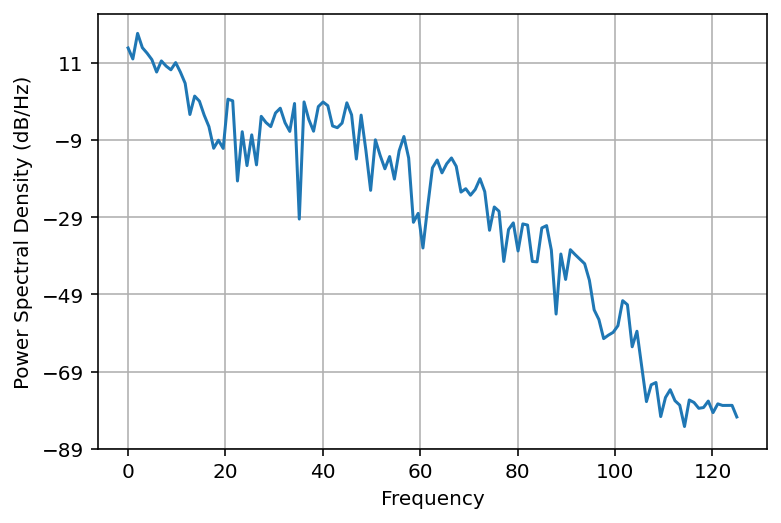

In [16]:
np.set_printoptions(suppress=True)

i = 0
b = 2500
X = ch_data[4,b+i*250:b+(i+1)*250]

# print(X)
plt.psd(X, Fs=250)

(129,)
(154,)
(129, 154)


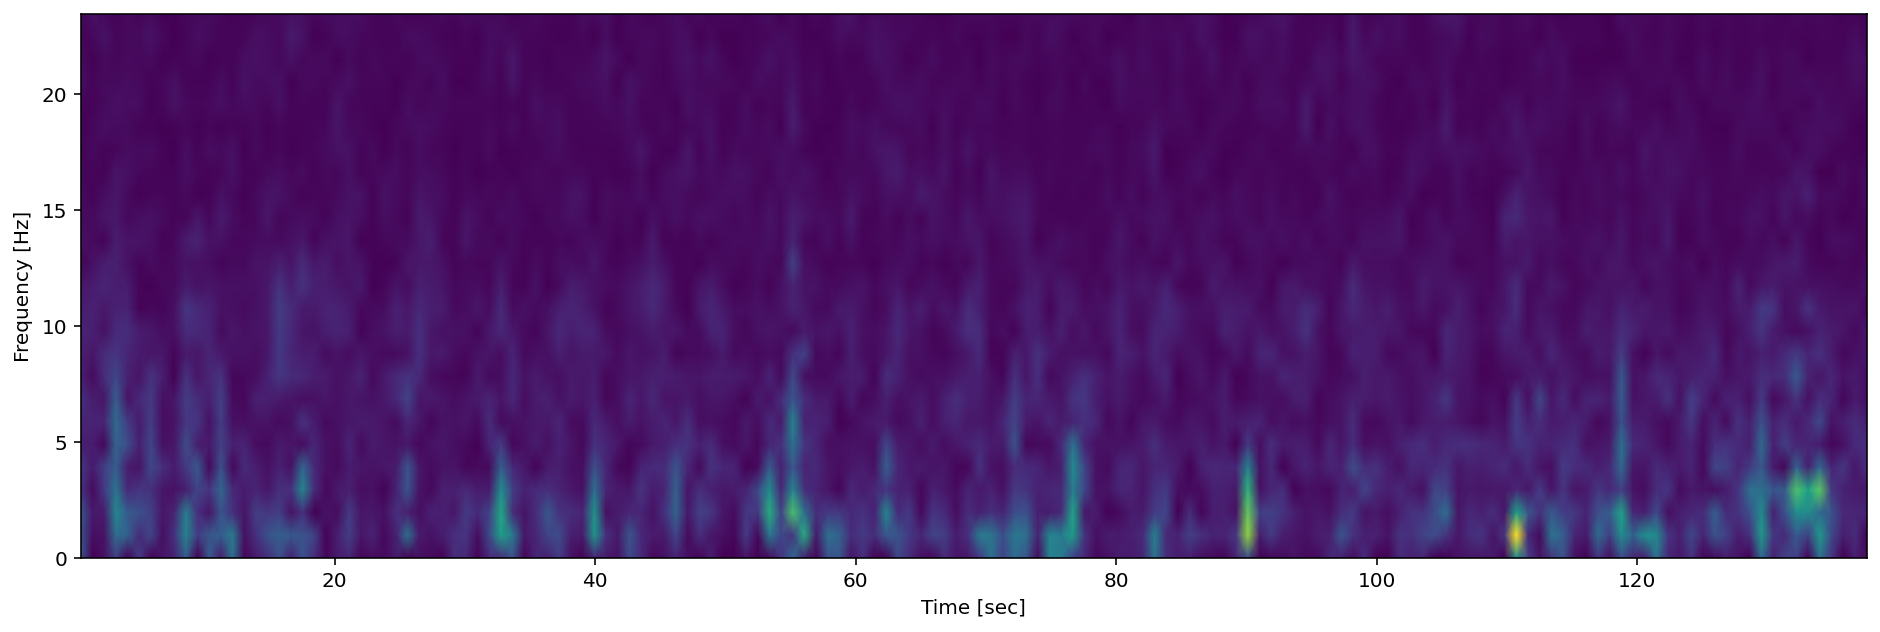

In [17]:
i = 0
b = 2500
l = 5000
# X = ch_data[4,b+i*l:b+(i+1)*l]
X = ch_data[4,b:]
figure(figsize=(16,5))
f, t, Sxx = signal.spectrogram(X, fs=250, window='hamming', nperseg=256, mode='magnitude' )
print(f.shape)
print(t.shape)
print(Sxx.shape)
plt.pcolormesh(t, f[:25], Sxx[:25], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

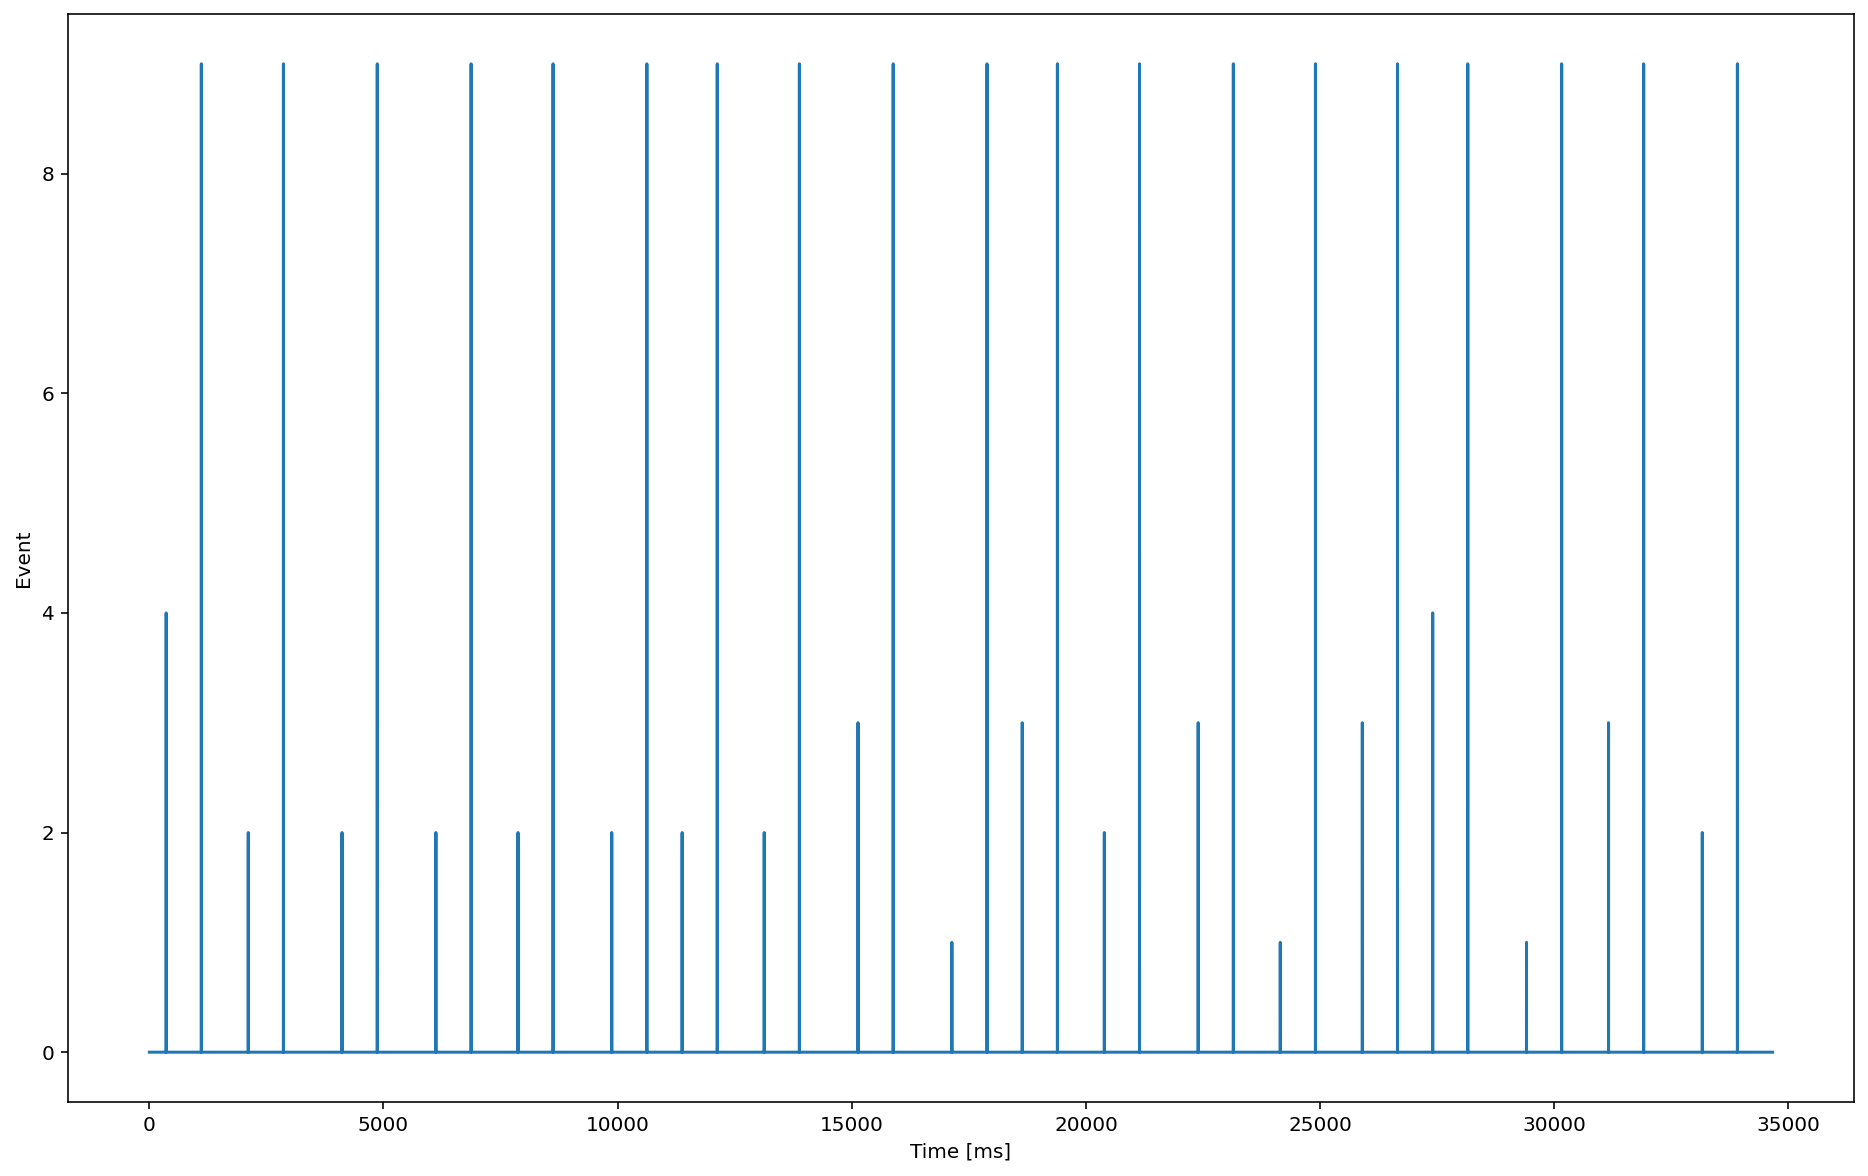

In [18]:
figure(figsize=(16,10))
# E_T = sorted_data[23,b+i*l:b+(i+1)*l]
E_T = sorted_data[23,b:]
plt.plot(range(len(E_T)), E_T)
plt.ylabel('Event')
plt.xlabel('Time [ms]')
plt.show()

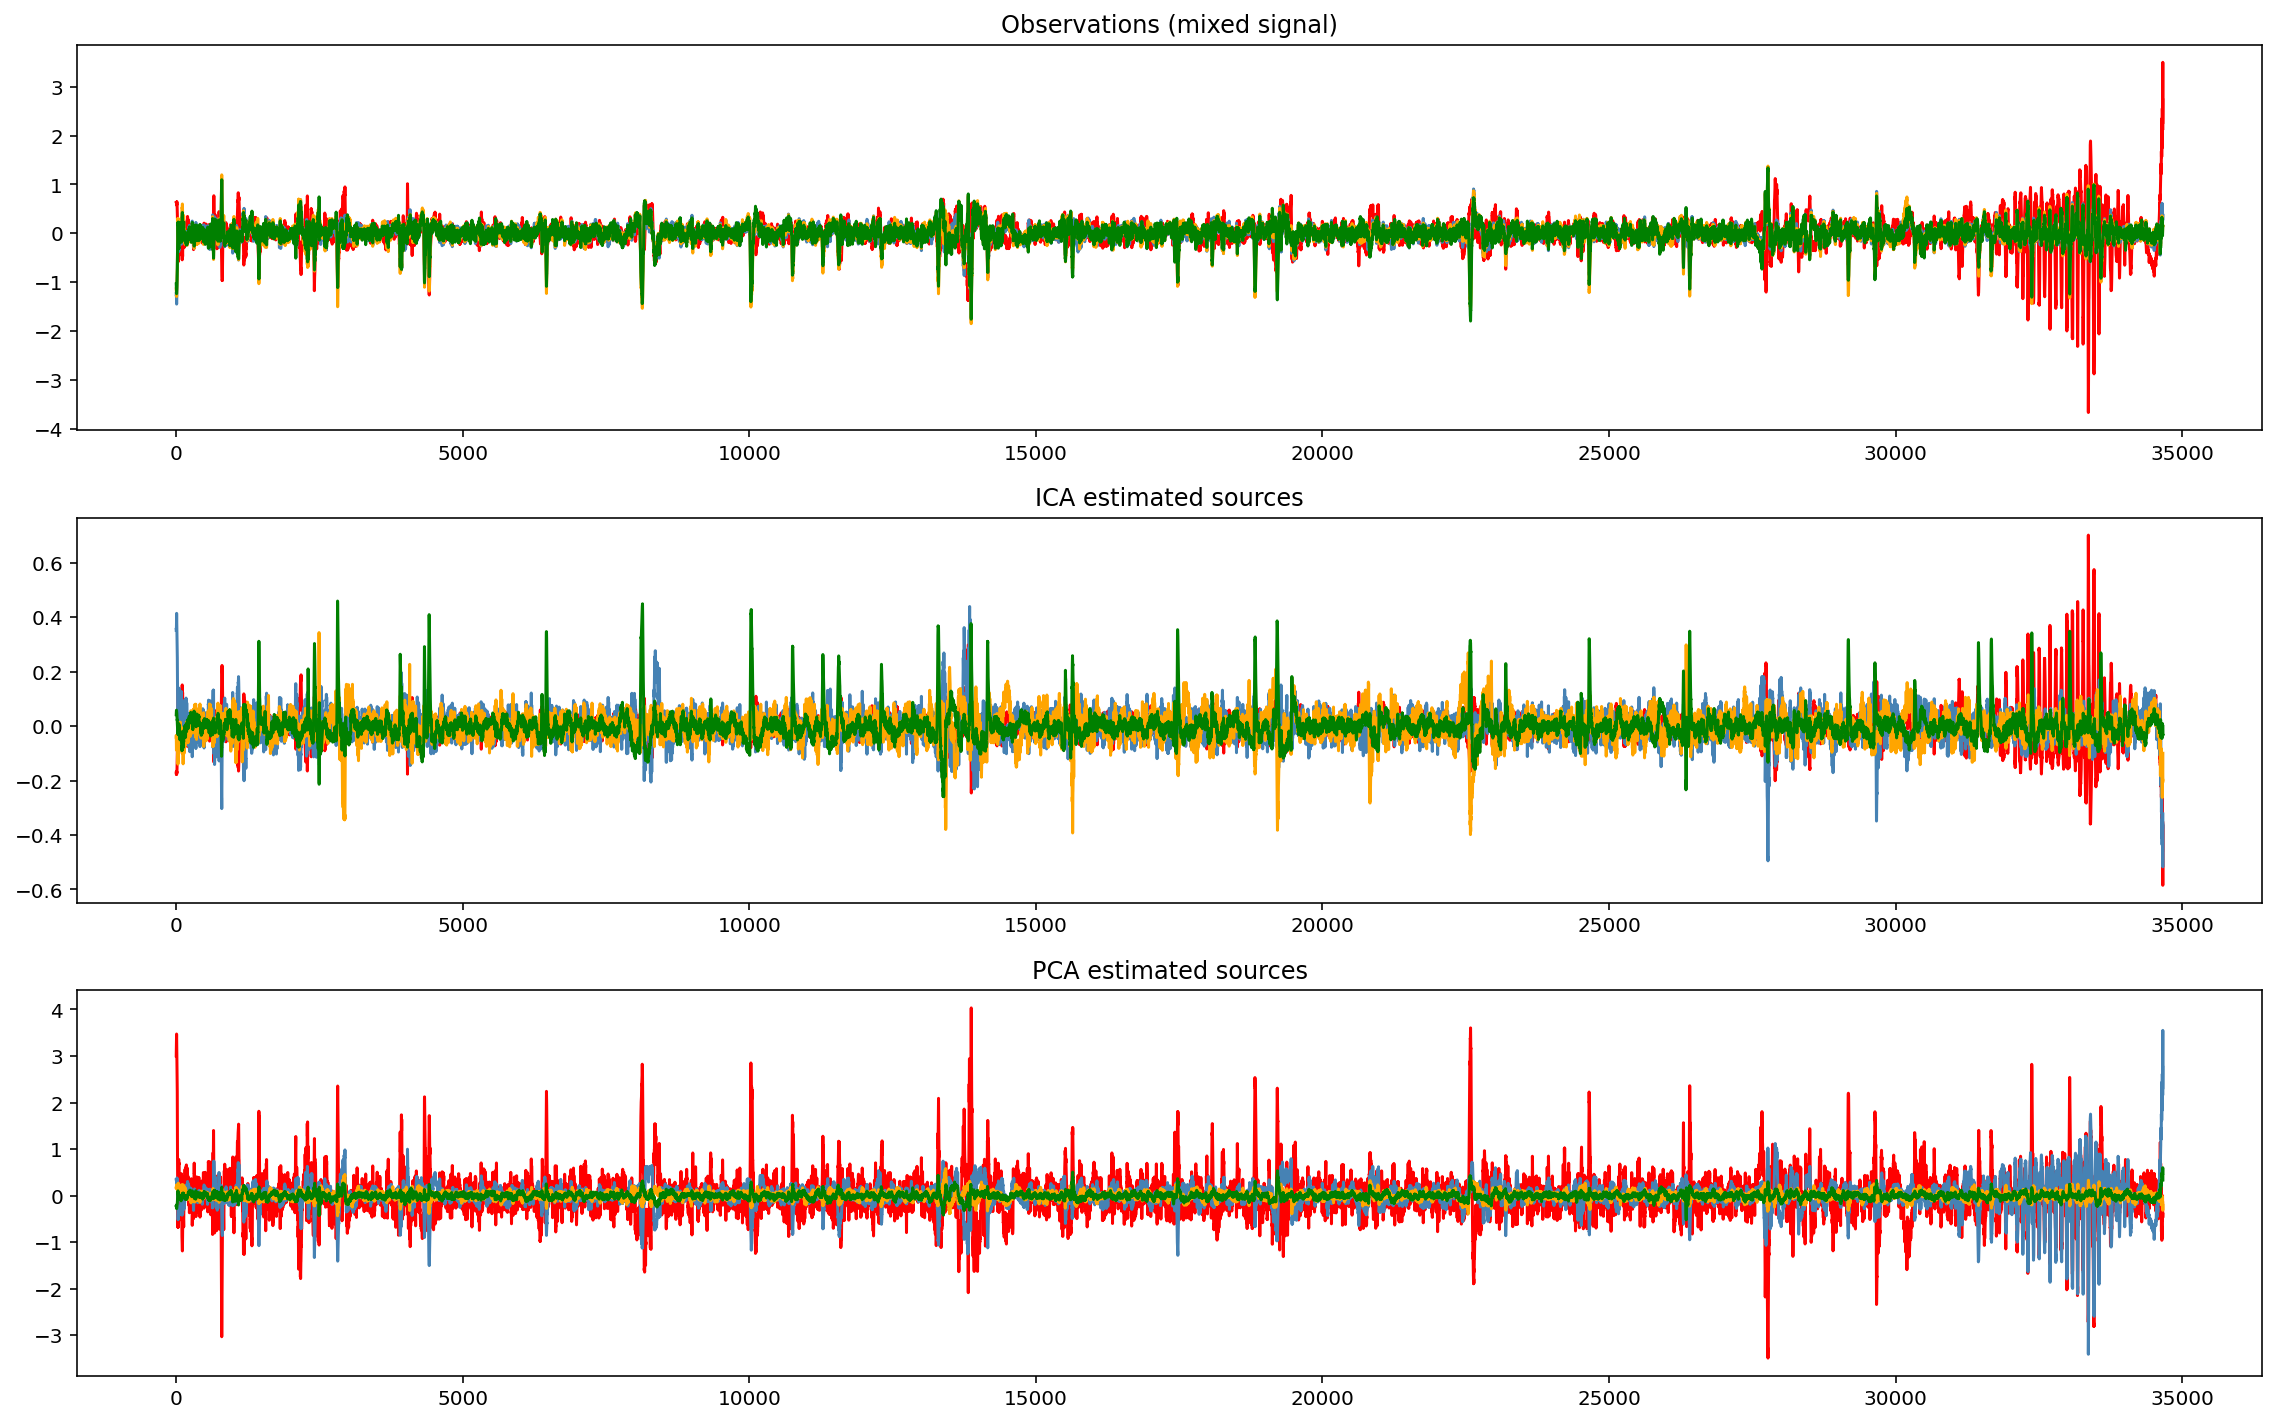

64.73371099999969


In [19]:
ch_data_T = ch_data[:,2500:].T

# compute ICA
ica = FastICA(n_components=4)
start_time = time.perf_counter() 
S_ = ica.fit_transform(ch_data_T)  # Get the estimated sources
end_time = time.perf_counter()
# A_ = ica.mixing_  # Get estimated mixing matrix

# compute PCA
pca = PCA(n_components=4)
H = pca.fit_transform(ch_data_T)  # estimate PCA sources

plt.figure(figsize=(16, 10))

models = [ch_data_T/100, S_*10, H/100]
names = ['Observations (mixed signal)',
         'ICA estimated sources',
         'PCA estimated sources']
colors = ['red', 'steelblue', 'orange', 'green']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()
print((end_time - start_time)*1000)

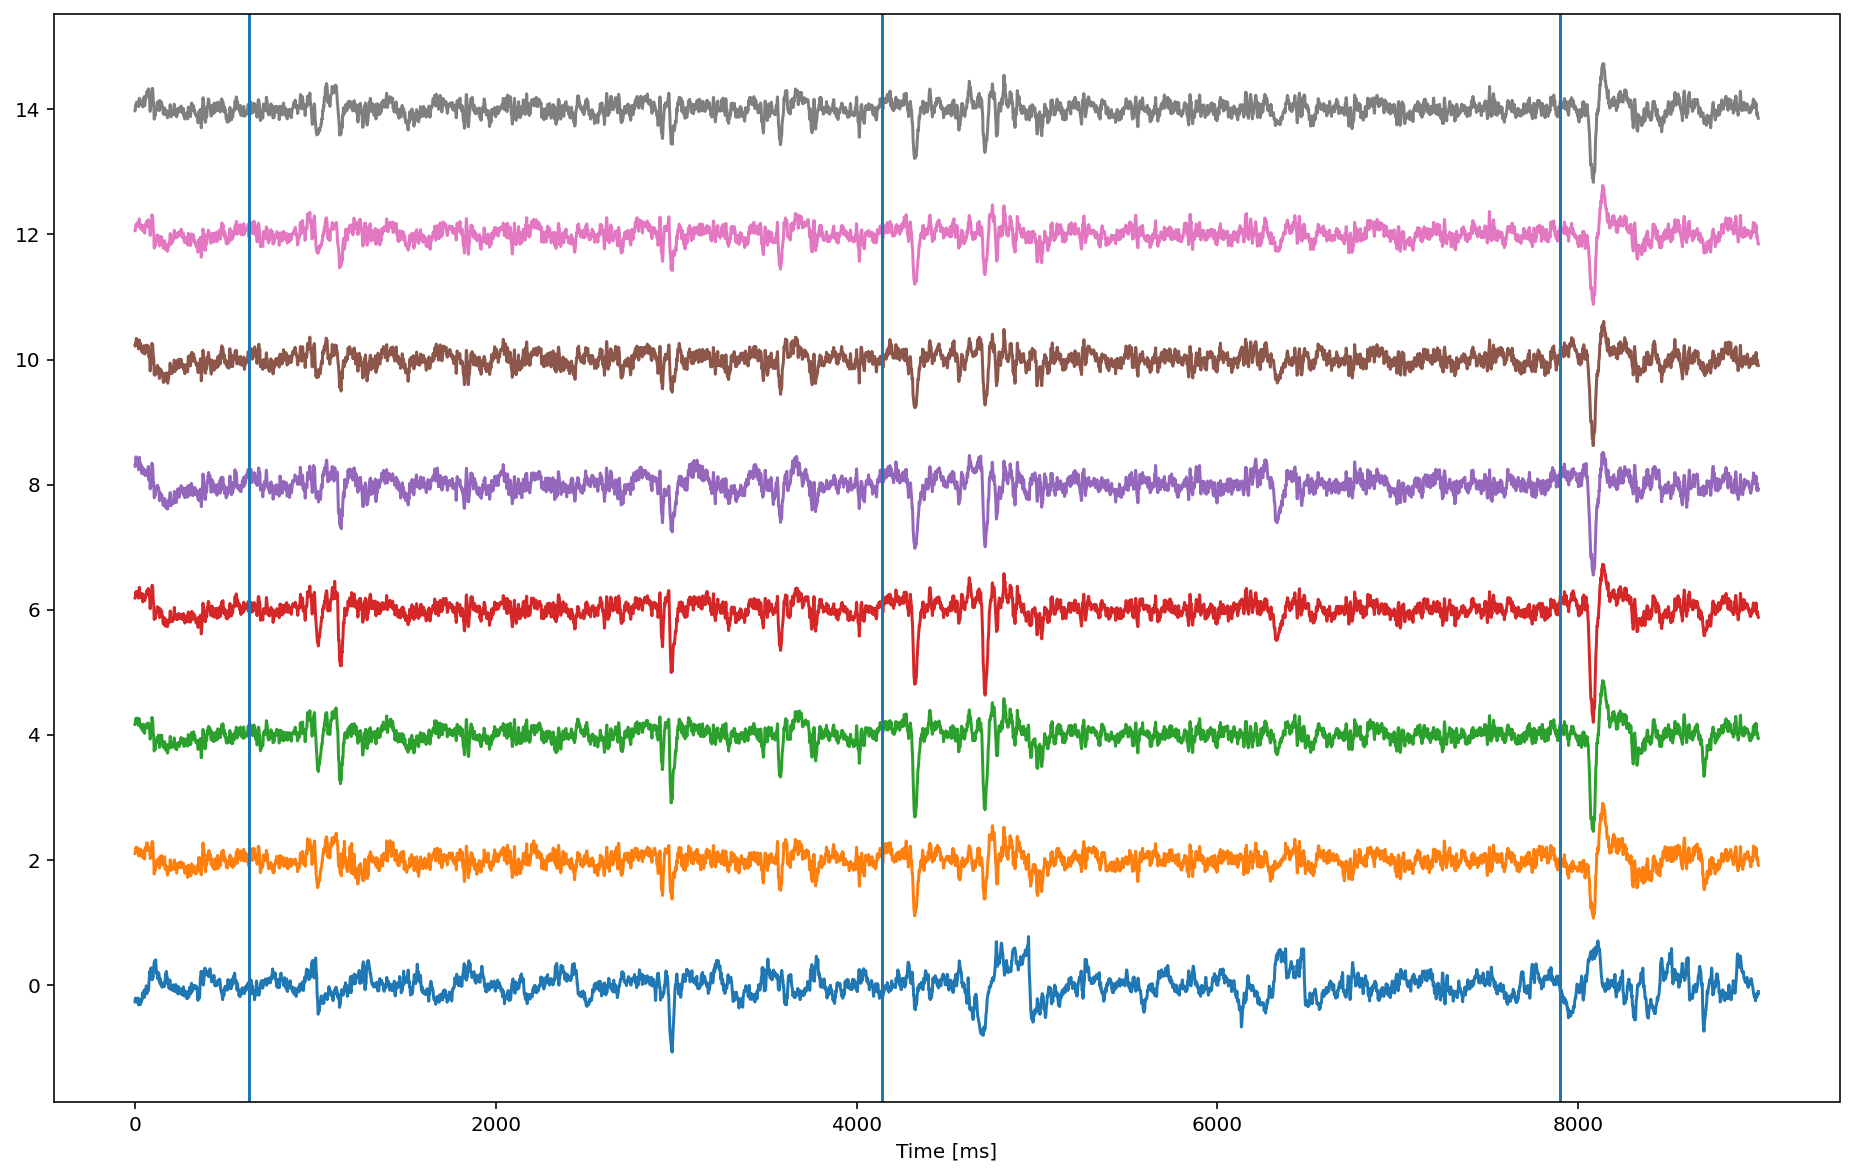

In [20]:
k = 15000
rng = [k+2000, k+11000]
figure(figsize=(16,10))
for i, ch in enumerate(ch_data[:,rng[0]:rng[1]]):
    plt.plot(range(len(ch)), ch/100+(i*2))
    
for i, ev in enumerate(sorted_data[23,rng[0]:rng[1]]):
    if ev == 3:
        plt.axvline(x=i)
        
# plt.ylabel('CHANNELS')
plt.xlabel('Time [ms]')
plt.show()

In [21]:
def center_channels(data):
    centered = []
    for ch in data:
        centered.append(ch - ch.mean())
    
    return np.array(centered)

In [22]:
def get_theshold_greatest(ch_data, threshold=0.05):
    max_ch = None
    cur_max = 0
    for i, ch in enumerate(ch_data):
        abs_ch = abs(ch)
        count = np.sum(np.where(abs_ch > 0.05))
        if count > cur_max:
            cur_max = count
            max_ch = i
            
    if max_ch == None:
        print('Warning: no channel data above threshold. Return 0 channel')
        max_ch = 0
        
    return max_ch
        

(7, 5)
(2600, 5)
[[ 0.02088801  0.01231882  0.00264011  0.01680725  0.01771639]
 [ 0.02112722  0.00909009  0.00577006  0.01177415  0.01633109]
 [ 0.01958503  0.00505724  0.00944159  0.01016542  0.01624736]
 [ 0.01631579  0.00378675  0.01265719  0.01377037  0.0118853 ]
 [ 0.01443752  0.00510621  0.0162413   0.01509963 -0.0009821 ]]
(2600, 7)
['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


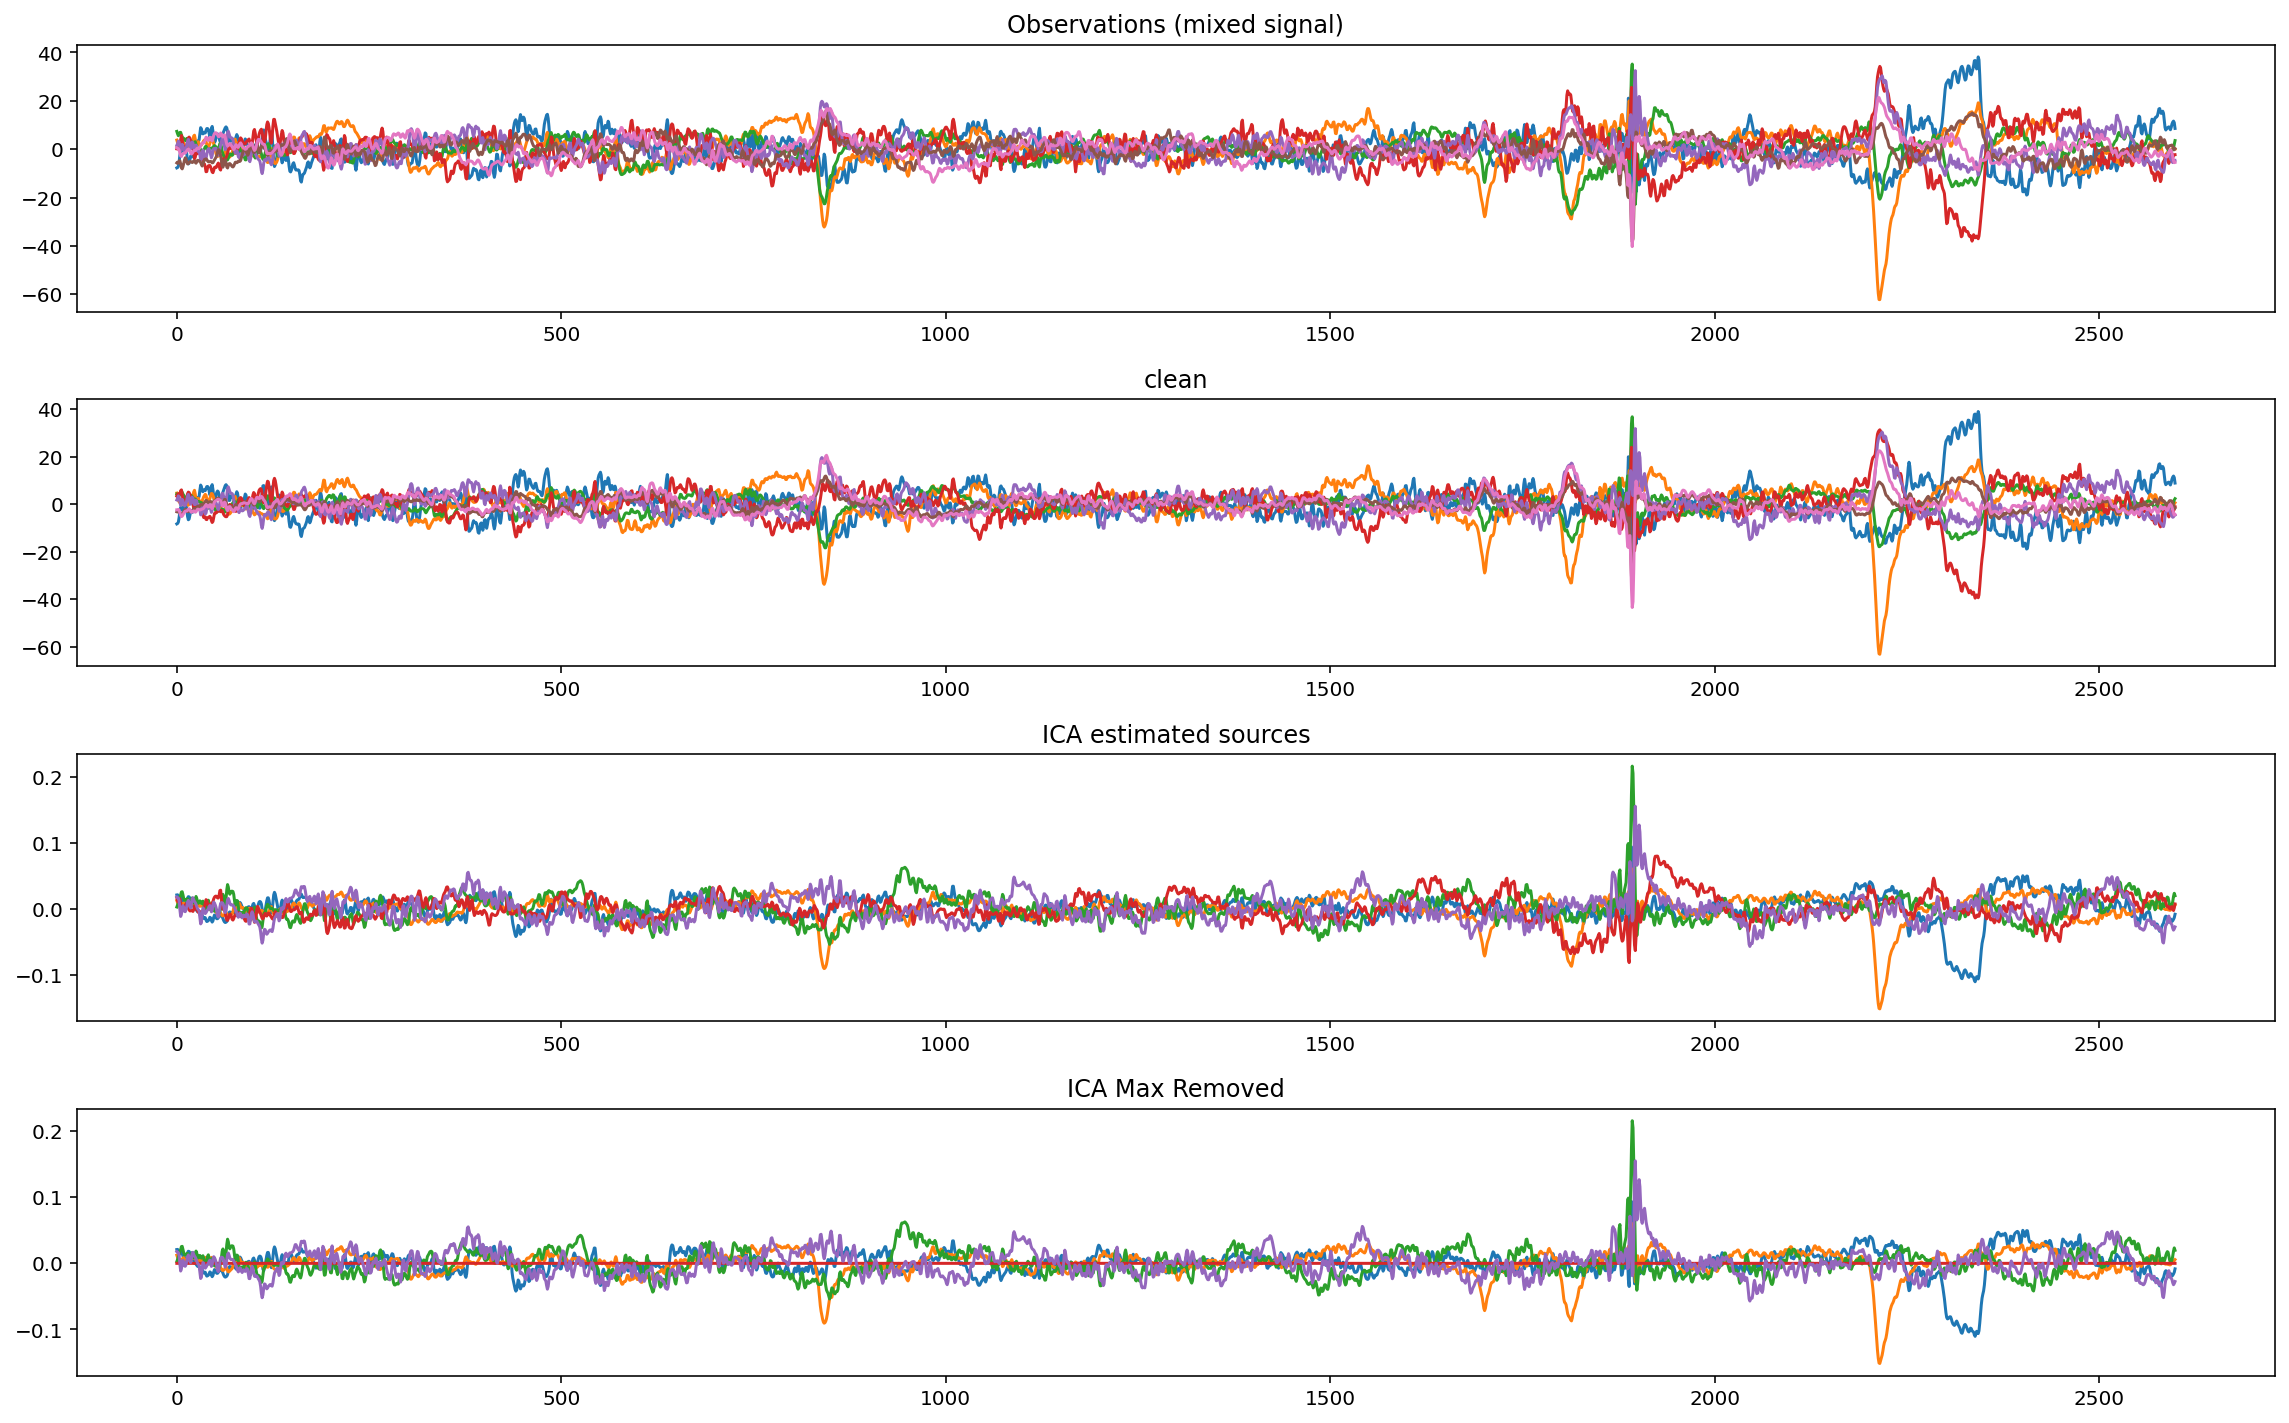

5.969668000034289


In [56]:
import matplotlib.colors as mcolors

ch_data_T = ch_data[1:,3100:5700].T
ch_data_T = center_channels(ch_data_T)

# compute ICA
ica = FastICA(n_components=5, max_iter=10000)
start_time = time.perf_counter() 
S_ = ica.fit_transform(ch_data_T)  # Get the estimated sources
end_time = time.perf_counter()
A_ = ica.mixing_  # Get estimated mixing matrix
U_ = ica.components_
print(A_.shape)
print(S_.shape)
print(S_[:5])
d = S_.copy()
# ch_remove = []
# for i, ch in enumerate(d.T):
#     ch_remove.append(max(ch))
    
# abs_S_ = abs(S_)
# print('source std:', np.std(abs_S_))
# print('source mean:', np.mean(abs_S_))
# print('source max:', np.max(abs_S_))
# print('mixed max:', np.max(abs(ch_data_T)))
# print(ch_remove)
# ch_remove =np.argmax(ch_remove)
# print(ch_remove)
ch_thsh_i = get_theshold_greatest(d.T, threshold=0.06)
# test_th_i = get_theshold_greatest(ch_data_T.T, threshold=14.41)



# print('test:', test_th_i)
# cc = ch_data_T[:,test_th_i]
# cc.shape = (-1, 1)
# print(cc)
        
d[:,ch_thsh_i] = 0
# print(d[:ch_remove])
F_ = np.dot(A_, d.T).T
print(F_.shape)
# print(A_)
# print(U_)
# print(ch_data_T.shape)

# compute PCA
pca = PCA(n_components=5)
H = pca.fit_transform(ch_data_T)  # estimate PCA sources

plt.figure(figsize=(16, 10))

models = [ch_data_T, F_, S_, d]
# models = [cc, F_, S_, d]
names = ['Observations (mixed signal)',
         'clean',
         'ICA estimated sources',
         'ICA Max Removed']
# colors = ['red', 'steelblue', 'orange', 'green']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = []
# for k in mcolors.TABLEAU_COLORS:
#     colors.append(k)
    
print(colors)
# CC = [mcolors.TABLEAU_COLORS[0,1,2,3,4,5,6,7],
#      mcolors.TABLEAU_COLORS[0,1,2,3,4,5,6,7],
#      mcolors.TABLEAU_COLORS[0,1,2,3],
#      mcolors.TABLEAU_COLORS[0,1,3]]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
#     for sig in model.T:
    for sig, color in zip(model.T, mcolors.TABLEAU_COLORS):
        plt.plot(sig, color=color)
# plt.plot(S_[:,0])
# print(S_.shape)

plt.tight_layout()
plt.show()
print((end_time - start_time)*1000)